In [1]:
# scipy
import scipy

# numpy
import numpy as np

# matplotlib
import matplotlib

# pandas
import pandas as pd

# scikit-learn
import sklearn


In [2]:
# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#load dataset
flights = pd.read_csv('flights_raw.txt')

#feature engineering
flights['fl_date'] = pd.to_datetime(flights['fl_date'], format='%Y-%m-%d')
flights['year'] = flights['fl_date'].dt.year
flights['month'] = flights['fl_date'].dt.month
flights['day'] = flights['fl_date'].dt.day
flights['arr_delay'] = flights['arr_delay'].fillna(0)
flights = flights.dropna()

#Dropping the outlier rows with standard deviation
factor = 3
upper_lim = flights['arr_delay'].mean() + flights['arr_delay'].std() * factor
lower_lim = flights['arr_delay'].mean() - flights['arr_delay'].std() * factor

flights = flights[(flights['arr_delay'] < upper_lim) & (flights['arr_delay'] > lower_lim)]

#binning distance
flights['bin_dist'] = pd.cut(flights['distance'], bins=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000], labels=[1,2,3,4,5,6,7,8,9,10])

#binning time
flights['bin_time'] = pd.cut(flights['crs_elapsed_time'], bins=[0,120,240,360,480,600,2000], labels=[1,2,3,4,5,6])

#log of distance
flights['log_dist'] = (flights['distance']+1).transform(np.log)

#log of elapsed time
flights['log_time'] = (flights['crs_elapsed_time']+1).transform(np.log)

#dummy encoding for op_unique_carrier
encoded_columns = pd.get_dummies(flights['op_unique_carrier'])
flights = flights.join(encoded_columns).drop('op_unique_carrier', axis=1)

flights.head()

,row_num,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,year,month,day,bin_dist,bin_time,log_dist,log_time,9E,9K,AA,AS,AX,B6,C5,CP,DL,EM,EV,F9,G4,G7,HA,KS,MQ,NK,OH,OO,PT,QX,UA,VX,WN,YV,YX,ZW
0,300,2018-01-01,B6,B6,B6,523,N984JB,523,12478,JFK,"New York, NY",12892,LAX,"Los Angeles, CA",1235,1550,N,375,1,2475,-6.0,2018,1,1,5,4,7.814400,5.929589,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,600,2018-01-01,B6,B6,B6,1224,N969JB,1224,12892,LAX,"Los Angeles, CA",12478,JFK,"New York, NY",1700,110,N,310,1,2475,17.0,2018,1,1,5,3,7.814400,5.739793,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,900,2018-01-01,HA,HA,HA,16,N373HA,16,12173,HNL,"Honolulu, HI",14679,SAN,"San Diego, CA",1505,2220,N,315,1,2614,44.0,2018,1,1,6,3,7.869019,5.755742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1200,2018-01-01,UA,UA_CODESHARE,UA,3443,N979RP,3443,11292,DEN,"Denver, CO",14457,RAP,"Rapid City, SD",1130,1249,N,79,1,300,-7.0,2018,1,1,1,1,5.707110,4.382027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1500,2018-01-01,AA,AA,AA,608,N742PS,608,11298,DFW,"Dallas/Fort Worth, TX",10397,ATL,"Atlanta, GA",1645,1948,N,123,1,731,-7.0,2018,1,1,2,2,6.595781,4.820282,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
flights.groupby('tail_num').size()

tail_num
215NV     10
216NV     12
217NV      9
218NV      4
219NV     11
220NV      4
221NV     11
222NV      5
223NV      8
224NV     11
225NV      6
226NV      5
227NV      8
228NV      9
229NV      9
230NV      7
231NV      6
232NV      2
233NV     13
234NV      6
235NV      4
240NV      7
241NV      8
242NV      4
243NV      3
244NV      2
245NV      1
246NV     13
247NV     11
248NV     18
249NV      3
250NV      7
251NV     13
252NV      8
253NV      9
254NV     16
255NV      8
256NV      7
257NV      6
258NV      5
259NV      6
260NV      1
261NV      7
262NV      3
271NV      4
272NV      7
273NV      3
274NV      4
275NV      1
276NV      4
279NV      3
282NV      4
283NV      1
301NV      6
302NV      9
303NV     10
304NV      4
305NV      6
306NV      7
307NV      5
308NV      3
309NV     10
310NV      5
311NV      6
312NV      8
313NV     15
314NV      1
315NV      5
316NV      3
317NV      3
318NV      8
319NV      3
320NV      5
321NV      4
322NV      6
323NV      4
324

C:\Users\jayta\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 2.292997
Kurtosis: 6.722883


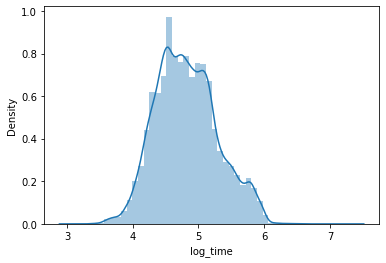

In [5]:
sns.distplot(flights['log_time']);

#skewness and kurtosis
print("Skewness: %f" % flights['arr_delay'].skew())
print("Kurtosis: %f" % flights['arr_delay'].kurt())

In [42]:
# Split-out validation dataset
features = ['origin_airport_id','dest_airport_id','crs_dep_time','log_time','month','log_dist','9E','AA','AS','AX','B6','C5','CP','DL','EM','EV','F9','G4','G7','HA','MQ','NK','OH','OO','PT','QX','UA','WN','YV','YX','ZW']
X = flights[features]
y = flights['arr_delay']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [43]:
test = test_df[features]

In [10]:
flights[features].to_csv('preprocessed_data.csv', index=False)

In [64]:
Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((41592, 31), (10398, 31), (41592, 1), (10398, 1))

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [25]:
x = X_train.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [26]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, Y_train], axis = 1)
pca.explained_variance_ratio_

array([0.06933828, 0.03944613])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

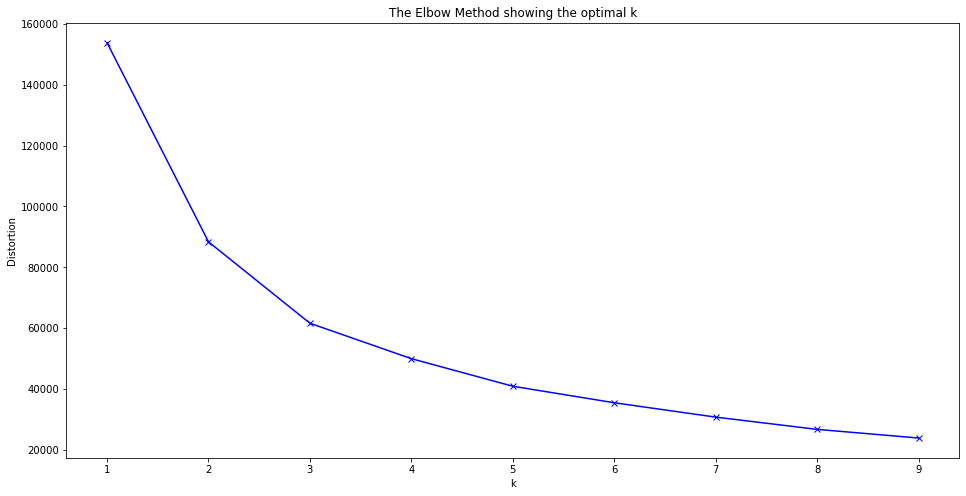

In [28]:
#clustering
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(principalDf)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [81]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(principalDf)

KMeans(n_clusters=3)

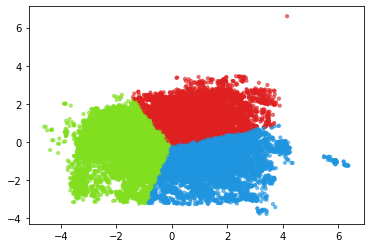

In [82]:
# k means
kmeans = KMeans(n_clusters=3, random_state=0)
principalDf['cluster'] = kmeans.fit_predict(principalDf[['principal component 1', 'principal component 2']])
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
principalDf['cen_x'] = principalDf.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
principalDf['cen_y'] = principalDf.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
principalDf['c'] = principalDf.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf.c, alpha = 0.6, s=10)

In [90]:
#logistic regression
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0).fit(X,y)

In [91]:
model.classes_

array([-72., -70., -68., -66., -64., -63., -60., -59., -58., -57., -56.,
       -55., -54., -53., -52., -51., -50., -49., -48., -47., -46., -45.,
       -44., -43., -42., -41., -40., -39., -38., -37., -36., -35., -34.,
       -33., -32., -31., -30., -29., -28., -27., -26., -25., -24., -23.,
       -22., -21., -20., -19., -18., -17., -16., -15., -14., -13., -12.,
       -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  8

In [92]:
model.score(X, y)

0.03646855164454703

In [61]:
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=2)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.036257 (0.000096)
LDA: 0.023033 (0.000433)
KNN: 0.018008 (0.000168)
CART: 0.018128 (0.000240)
NB: 0.000289 (0.000144)


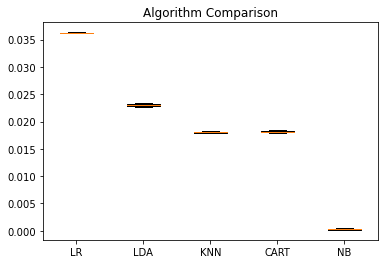

In [62]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()